# Churchland Widefield Data

This notebook demonstrates:
- Decoding L/R choice from different periods of the delay period

In [1]:
import numpy as np
import pandas as pd
import ssm
import seaborn as sns
import numpy.random as npr
import matplotlib.pyplot as plt
import numpy.linalg as la
from collections import OrderedDict
from matplotlib.font_manager import FontProperties
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from ssm import LDS
from Session import *
from LVM import *

In [2]:
from matplotlib.cm import get_cmap
cmap = get_cmap('coolwarm')

## 1. Load data and BehaveNet reconstructions for the best model

In [3]:
def undo_zscore(neural, predictions):
    """
    Assumes data is trial x time x components
    
    Args:
        neural: original neural activity
        predictions: predicted z-scored activity
    Returns:
        predictions with the z-scoring undone
    """

    predictions = predictions.copy()
    predictions *= np.std(neural, axis=(0,1))
    predictions += np.mean(neural, axis=(0,1))
    return predictions

def zscore(data):
    """
    Assumes data is trial x time x components
    """

    data -= np.mean(data, axis=(0,1))
    data /= np.std(data, axis=(0,1))
    return data

In [4]:
session = Session("vistrained", "mSM30", "10-Oct-2017")
all_neural_data = session.neural['neural']
delay_period_indices = session.get_delay_period(include_stim=True)
excerpt_indices = []
for trial in range(delay_period_indices.shape[0]):
    start = delay_period_indices[trial,:][0] - 30
    end = delay_period_indices[trial,:][0] + 90
    excerpt_indices.append([start, end])
trial_choices = session.trialmarkers['ResponseSide']

In [5]:
bn_version = 'version_223'
ffdatadir = "/home/chingf/Code/Widefield/analysis/musall/vistrained/mSM30/10-Oct-2017/ae-neural/16_latents/ff/all/test/"
predictions_file = ffdatadir + bn_version + "/" + "predictions.pkl"
with open(predictions_file, "rb") as f:
    predictions_data = pickle.load(f)
predictions = np.nan_to_num(
    predictions_data['predictions']
    )
scaled_predictions = undo_zscore(all_neural_data, predictions)
predictions_trials = predictions_data['trials']

In [6]:
# Extract bins of interest
predictions_excerpt = []
for trial in range(scaled_predictions.shape[0]):
    activity = scaled_predictions[trial,:,:]
    indices = excerpt_indices[trial]
    predictions_excerpt.append(activity[indices[0]:indices[1],:])
scaled_predictions = np.array(predictions_excerpt)

## 2. Decoding: Which time periods are most predictive?
### Features: flattened neural activity

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

In [30]:
def fit_LR(start_idx, window_length):
    """
    Fits a L2-regularized logistic regression model, predicting
    left/right licking choice.
    
    Args
        start_idx: index in delay period to start extracting a window
            of activity.
        window_length: size of the window of activity to extract
    """
    
    X = []
    y = []
    # Extracting training and test data
    for trial in range(trial_choices.size):
        choice = trial_choices[trial]
        if np.isnan(choice):
            continue
        activity = scaled_predictions[trial,start_idx:start_idx+window_length,:]
        X.append(activity.flatten())
        y.append(int(choice-1))
    X = np.array(X)
    y = np.array(y)
    
    # Training the model with cross validation
    log_reg = LogisticRegressionCV(
        Cs=5, cv=5, scoring='accuracy', max_iter=500
        )
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    log_reg.fit(X, y)
    return log_reg

In [34]:
# Do a grid search over start index and window length
# Fit logistic regression models
window_length = 2
results = []

start_idxs = range(0, 120, 2)
for start_idx in start_idxs:
    log_reg = fit_LR(start_idx, window_length)
    results.append(log_reg)

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

In [40]:
# Save the logistic regression models
pickle.dump(results, open("temporaldecoding_reconstructions.p", "wb" ) )

## 3. Decoding: Which regions are most predictive?
### Using window frames of length 2 frames

In [8]:
# Extract the results corresponding to window_size = 2
with open("temporaldecoding_reconstructions.p", "rb") as f:
    results = pickle.load(f)

In [9]:
reg_indxs = session.neural['reg_indxs_consolidate'].item()
reg_names = session.neural['reg_indxs_consolidate'].dtype.names

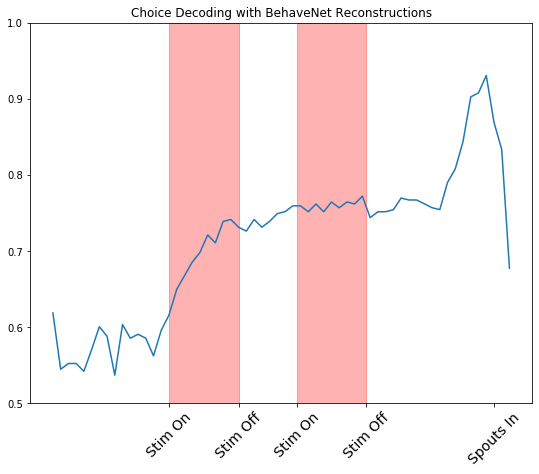

In [48]:
start_frame = []
accuracy = []
plt.figure(figsize=(9,7))
for frame, log_reg in enumerate(results):
    if log_reg == None:
        continue
    start_frame.append(frame*2)
    accuracy.append(
        np.max(np.mean(log_reg.scores_[1], axis=0))
        )
plt.xticks(
    ticks=[30, 30+18, 30+33, 30+51, 30+84],
    labels=['Stim On', 'Stim Off', 'Stim On', 'Stim Off', 'Spouts In'],
    rotation=45, fontsize=14
    )
plt.axvspan(30, 30+18, alpha=0.3, color='red')
plt.axvspan(30+33, 30+51, alpha=0.3, color='red')
plt.title("Choice Decoding with BehaveNet Reconstructions")
plt.ylim((0.5,1))
sns.lineplot(x=start_frame, y=accuracy)

In [10]:
# Collect coefficient values
coef_values_df = {}
coef_values_df['Trial Event'] = []
coef_values_df['Coefficients'] = []
coef_values_df['Brain Region'] = []
frames = [14/2, 40/2, 56/2, 72/2, 90/2]
events = ['Pre-Stim', 'Stim 1', 'Between Stims', 'Stim 2', 'Delay']

# Iterate over each region
session = Session("vistrained", "mSM30", "10-Oct-2017", access_engram=True, load_behavenet=False)
reg_indxs = session.neural['reg_indxs_consolidate'].item()
reg_names = session.neural['reg_indxs_consolidate'].dtype.names
for idx, reg_name in enumerate(reg_names):
    components = reg_indxs[idx].squeeze()

    # For each component in a region
    for component in components:
        # For each time step, collect the relevant coefficient values
        for idx, log_reg in enumerate(results):
            if idx not in frames:
                continue
            normalized_coefs = normalize(log_reg.coef_).squeeze()
            coef_values_df['Trial Event'].append(events[frames.index(idx)])
            coef_values_df['Coefficients'].append(
                np.abs(normalized_coefs[component-1]) # Components is 1-indexed!
                )
            coef_values_df['Brain Region'].append(reg_name)
coef_values_df = pd.DataFrame(data=coef_values_df)

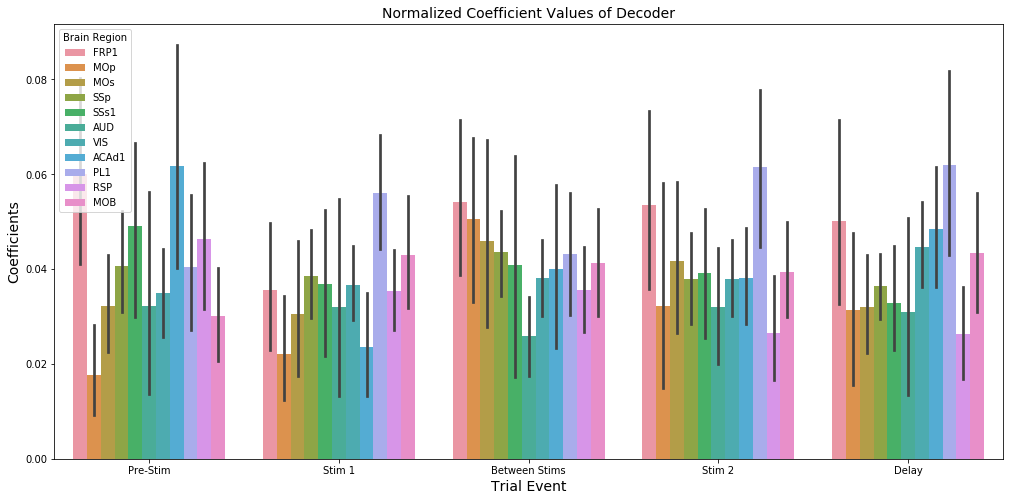

In [11]:
plt.figure(figsize=(17,8))
plt.title("Normalized Coefficient Values of Decoder", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.xlabel("Trial Event", fontsize=14)
ax = sns.barplot(
    x="Trial Event", y="Coefficients", hue="Brain Region", data=coef_values_df
    )

#### Scatterplot of each component at a single time point

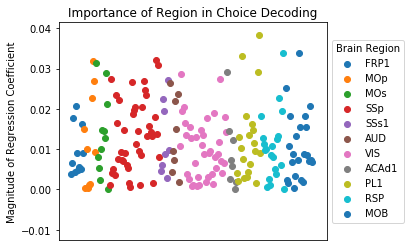

In [18]:
fig = plt.figure()
ax = plt.subplot(111)
start_x = 0
log_reg = len2_results[40]
for idx, reg_name in enumerate(reg_names):
    reg_indx = reg_indxs[idx].squeeze()
    plt.scatter(
        x=np.arange(reg_indx.size) + start_x,
        y=np.abs(log_reg.coef_.squeeze()[reg_indx]),
        label=reg_name
        )
    start_x += reg_indx.size

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(
    title="Brain Region",
    loc='center left', bbox_to_anchor=(1, 0.5)
    )

plt.title("Importance of Region in Choice Decoding")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    labelbottom=False # labels along the bottom edge are off
    )
plt.ylabel("Magnitude of Regression Coefficient")
plt.show()

#### Plot of regional importance over time

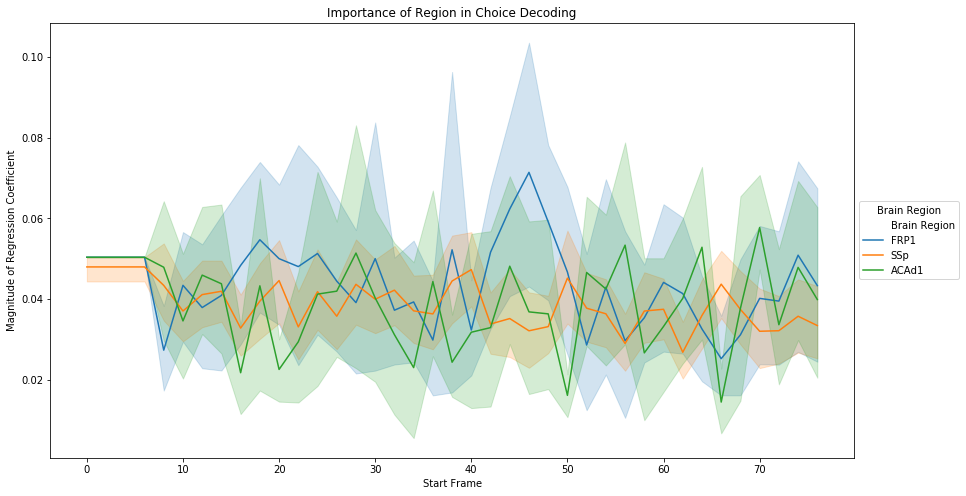

In [19]:
coef_values_df = {}
coef_values_df['Start Frame'] = []
coef_values_df['Coefficients'] = []
coef_values_df['Brain Region'] = []

# Iterate over each region
for idx, reg_name in enumerate(reg_names):
    if reg_name not in ['FRP1', 'ACAd1', 'SSp']:
        continue
    components = reg_indxs[idx].squeeze()
    
    # For each component in a region
    for component in components:
        
        # For each time step, collect the relevant coefficient values
        for idx, log_reg in enumerate(len2_results):
            if log_reg == None:
                continue
            normalized_coefs = normalize(log_reg.coef_).squeeze()
            coef_values_df['Start Frame'].append(idx)
            coef_values_df['Coefficients'].append(
                np.abs(normalized_coefs[component])
                )
            coef_values_df['Brain Region'].append(reg_name)
            

# Plot each regions values as a lineplot
coef_values_df = pd.DataFrame(data=coef_values_df)
fig = plt.figure(figsize=(18,8))
ax = sns.lineplot(
    x="Start Frame", y="Coefficients",
    hue="Brain Region", data=coef_values_df)
    
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(
    title="Brain Region",
    loc='center left', bbox_to_anchor=(1, 0.5)
    )

plt.title("Importance of Region in Choice Decoding")
plt.xlabel("Start Frame")
plt.ylabel("Magnitude of Regression Coefficient")
plt.show()